In [24]:
import SimPEG as simpeg
from SimPEG import NSEM
from glob import glob
import numpy as np, sys, matplotlib.pyplot as plt
# sys.path.append('/home/gudni/Dropbox/Work/UBCwork/SyntheticModels/SynGeothermalStructures/ThesisModels')
# import synhelpFunc
%matplotlib inline

In [25]:
def convergeCurves(resList,ax1,ax2,color1,color2,fontsize):
    its  = np.array([res['iter'] for res in resList]).T
    ind = np.argsort(its)
    phid = np.array([res['phi_d'] for res in resList]).T
    try:
        phim = np.array([res['phi_m'] for res in resList]).T
    except:
        phim = np.array([res['phi_ms'] for res in resList]).T + np.array([res['phi_mx'] for res in resList]).T + np.array([res['phi_my'] for res in resList]).T + np.array([res['phi_mz'] for res in resList]).T     
    x = np.arange(len(its))

    ax1.set_title('Data misfit $\phi_d$ and regularization $\phi_m$',fontsize=fontsize)
    ax1.semilogy(x,phid[ind],'o--',color=color1)
    ax1.set_ylabel('$\phi_d$',fontsize=fontsize)
    ax1.hlines(len(resList[0]['dpred'])*.5,0,len(x),colors='black',linestyles='-.')
    #for tl in ax1.get_yticklabels():
    #    tl.set_color(color1)
         
    ax2.semilogy(x,phim[ind],'x--',color=color2)
    ax2.set_ylabel('$\phi_m$',fontsize=fontsize)
    #for tl in ax2.get_yticklabels():
    #    tl.set_color(color2)
    ax1.set_xlabel('iteration',fontsize=fontsize)
    
    ax1.tick_params(axis='x',labelsize=fontsize)
    ax1.tick_params(axis='y',labelsize=fontsize)
    ax2.tick_params(axis='y',labelsize=fontsize)
    
    return ax1,ax2
    
def tikanovCurve(resList):
    its  = np.array([res['iter'] for res in resList]).T
    ind = np.argsort(its)
    phid = np.array([res['phi_d'] for res in resList]).T
    phim = np.array([res['phi_m'] for res in resList]).T
    x = np.arange(len(its))
    fig, ax1 = plt.subplots()
    ax1.loglog(phim[ind],phid[ind],'bx--')
    ax1.set_ylabel('phi_d')
    ax1.set_xlabel('phi_m')
    plt.hlines(len(resList[0]['dpred'])*.75,np.min(phim),np.max(phim),colors='g',linestyles='-.')
    plt.show()
    
def allconvergeCurves(resList):
    its  = np.array([res['iter'] for res in resList]).T
    ind = np.argsort(its)
    phid = np.array([res['phi_d'] for res in resList]).T
    #phim = np.array([res['phi_m'] for res in resList]).T
    phims = np.array([res['phi_ms'] for res in resList]).T
    phimx = np.array([res['phi_mx'] for res in resList]).T
    phimy = np.array([res['phi_my'] for res in resList]).T
    phimz = np.array([res['phi_mz'] for res in resList]).T
    x = np.arange(len(its))
    fig, ax1 = plt.subplots()
    ax1.semilogy(x,phid[ind],'bx--',label='phid')
    ax1.set_ylabel('phi_d', color='b',fontsize=fontsize)
    
    plt.hlines(len(resList[0]['dpred'])*.75,0,len(x),colors='g',linestyles='-.')
    for tl in ax1.get_yticklabels():
        tl.set_color('b')         
    #ax1.semilogy(x,phim[ind],'gx--',label='phim')
    ax1.semilogy(x,phims[ind],'y,--',label='phims')
    ax1.semilogy(x,phimx[ind],'r.--',label='phimx')
    ax1.semilogy(x,phimy[ind],'r+--',label='phimy')
    ax1.semilogy(x,phimz[ind],'r*--',label='phimz')
    
    plt.legend()
    plt.show()

def loadInversionMakeVTRFiles(dirStr,mesh,mapping):
    temp = [np.load(f) for f in glob(dirStr+'/*Inversion*.npz')]
    iterResults = [i if len(i.keys()) > 1 else i['arr_0'].tolist() for i in temp ]
    # Make the vtk models
    for it in iterResults:
        mesh.writeVTK(dirStr+'/recoveredMod_{:s}_it{:.0f}.vtr'.format(dirStr,int(it['iter'])),{'S/m':mapping*it['m']})
    return iterResults

def getDataInfo(MTdata):

    dL, freqL, rxTL = [], [], []

    for src in MTdata.survey.srcList:
        for rx in src.rxList:
            dL.append(MTdata[src,rx])
            freqL.append(np.ones(rx.nD)*src.freq)
            rxTL.extend( ((rx.rxType+' ')*rx.nD).split())
    return np.concatenate(dL), np.concatenate(freqL), np.array(rxTL)


In [26]:
# Load the model
mesh, modDict = simpeg.Mesh.TensorMesh.readVTK('../ForwardModeling_noExtension_Coarse/nsmesh_CoarseHKPK1_NoExtension.vtr')
sigma = modDict['S/m']

In [27]:
# Make the mapping
active = sigma != 1e-8
actMap = simpeg.Maps.InjectActiveCells(mesh, active, np.log(1e-8), nC=mesh.nC)
mappingExpAct = simpeg.Maps.ExpMap(mesh) * actMap

### Run_thibaut4_offdiagonal inversion

In [28]:
# Load the off-diagonal observed data
drecAll = np.load('./run_thibaut4_off/MTdataStArr_nsmesh_HKPK1Coarse_noExtension.npy')
# Select larger frequency band for the MT data
indMTFreq = np.sum([drecAll['freq'] == val for val in  np.unique(drecAll['freq'])],axis=0,dtype=bool)
mtRecArr = drecAll[indMTFreq][['freq','x','y','z','zxy','zyx']]
dUse = NSEM.Data.fromRecArray(mtRecArr)
# Extract to survey
survey = dUse.survey

In [29]:
#Extract the structure of the observed data and reproduce the error tolerances

dobs, freqArr, rxT = getDataInfo(dUse)
# Set the data

survey.dobs = dobs

#Find index of each type of data
offind = np.array([('zxy' in l or 'zyx' in l) for l in rxT],bool)
tipind = np.array([('tzy' in l or 'tzx' in l) for l in rxT],bool)

#Check if we got all data type covered
assert (offind + tipind).all() , 'Some indicies not included'

#Initialize std
std = np.zeros_like(dobs) # 5% on all off-diagonals

#Std for off diagonal 5% + 0.001*median floor
std = np.abs(survey.dobs*0.05)

#std for tipper: floor of 0.001*median
#std[tipind] = np.abs(np.median(survey.dobs[tipind])*0.001)
# std[np.array([ ('xx' in l or 'yy' in l) for l in rxT])] = 0.15 # 15% on the on-diagonal
survey.std = std 
# Estimate a floor for the data.
# Use the 10% of the mean of the off-diagonals for each frequency
#onind = np.array([('zxx' in l or 'zyy' in l) for l in rxT],bool)

floor = np.zeros_like(dobs)
#floortip = 0.001

for f in np.unique(freqArr):
    freqInd = freqArr == f
    floorFreq = floor[freqInd]
    offD = np.sort(np.abs(dobs[freqInd*offind]))
    floor[freqInd] = 0.001*np.mean(offD)
    # onD = np.sort(np.abs(dobs[freqInd*onind]))
    # floor[freqInd*onind] = 0.1*np.mean(onD)

#floor[tipind] = floortip

# Assign the data weight
Wd = 1./(survey.std + floor)

eps=(survey.std + floor)

In [30]:
#Load the iterations from inversions
runT4fFiles = loadInversionMakeVTRFiles('run_thibaut4_off',mesh,mappingExpAct)

In [31]:
print runT4fFiles[-1]

{'dpred': array([ -3.24781003,  -2.8784831 ,  -2.48161968, ...,  27.30599333,
        29.03636921,  31.28780134]), 'f': 15395.506490029129, 'm': array([-9.21095429, -9.21107076, -9.21115512, ..., -9.21775515,
       -9.21870692, -9.21962864]), 'iter': 18, 'beta': 0.00024568852665015755, 'phi_my': 8940.5940464691121, 'phi_d': 14356.7114247545, 'phi_mz': 37163.51463371898, 'phi_ms': 357.1547391768604, 'phi_mx': 8041.8808941840671}


In [32]:
#extract last dpred
dpred = runT4fFiles[-1]['dpred']

In [33]:
runT4fFiles[-1]['iter']

18

In [34]:
# Load the tipper data
drecAllt = np.load('./run_thibaut4_tip/MTdataStArr_nsmesh_HKPK1Coarse_noExtension.npy')
# Select larger frequency band for the MT data
indMTFreqt = np.sum([drecAllt['freq'] == val for val in  np.unique(drecAllt['freq'])],axis=0,dtype=bool)
mtRecArrt = drecAllt[indMTFreqt][['freq','x','y','z','tzx','tzy']]
dUset = NSEM.Data.fromRecArray(mtRecArrt)
# Extract to survey
survey = dUset.survey

# # Add noise to the data
dobst, freqArr, rxT = getDataInfo(dUset)
# Set the data

survey.dobs = dobst
# Assign std based on- and off-diagonal parts of the impedance tensor
std = np.ones_like(dobst)*.05 # 5% on all off-diagonals
# std[np.array([ ('xx' in l or 'yy' in l) for l in rxT])] = 0.15 # 15% on the on-diagonal
survey.std = np.abs(survey.dobs*std) #+ 0.01*np.linalg.norm(survey.dobs) #survey.dobs*0 + std
# Estimate a floor for the data.
# Use the 10% of the mean of the off-diagonals for each frequency
floor = np.zeros_like(dobst)
offind = np.array([('zxy' in l or 'zyx' in l) for l in rxT],bool)
onind = np.array([('zxx' in l or 'zyy' in l) for l in rxT],bool)
tipind = np.array([('tzx' in l or 'tzy' in l) for l in rxT],bool)

assert (offind+tipind+onind).all()

for f in np.unique(freqArr):
    freqInd = freqArr == f
    floorFreq = floor[freqInd]
    offD = np.sort(np.abs(dobst[freqInd*offind]))
    floor[freqInd] = 0.0001*np.mean(offD)
    onD = np.sort(np.abs(dobst[freqInd*onind]))
    floor[freqInd*onind] = 0.1*np.mean(onD)
    # Constant floor for the tipper.
    floor[freqInd*tipind] = 0.001

# Assign the data weight
Wd = 1./(survey.std + floor)

epst=(survey.std + floor)

In [35]:
#load tipper inversion
runT4tFiles = loadInversionMakeVTRFiles('run_thibaut4_tip',mesh,mappingExpAct)

In [36]:
#extract final predicted data
dpredt =runT4tFiles[-1]['dpred']

In [37]:
runT4tFiles[-1]['iter']

36

In [38]:
#Normalized misfit
phi_d = (dpred-dobs)/eps
phi_d_t=(dpredt-dobst)/epst

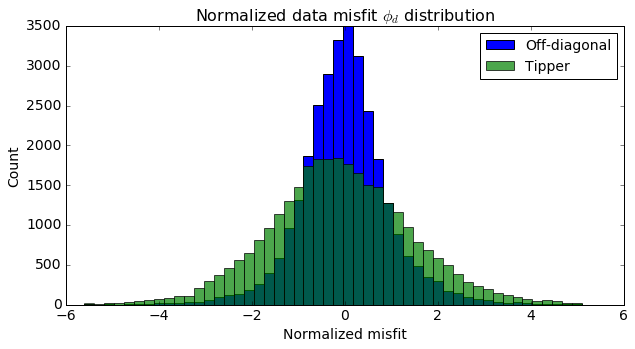

In [39]:
#Visualisation Data Misfit
fig=plt.figure(figsize=(10,5))
ax=plt.subplot(111)

n0 = ax.hist(phi_d,bins=50,color='blue')
n1 = ax.hist(phi_d_t,bins=n0[1],color='green',alpha=0.7)

ax.set_xlabel('Normalized misfit',fontsize=14)
ax.set_ylabel('Count',fontsize=14)
ax.set_title('Normalized data misfit $\phi_d$ distribution',fontsize=16)
ax.tick_params(axis='x',labelsize=14)
ax.tick_params(axis='y',labelsize=14)
ax.legend(('Off-diagonal','Tipper'),fontsize=14)

fig.savefig('../Poster/MT_Normalized_misfit.png',dpi=300)

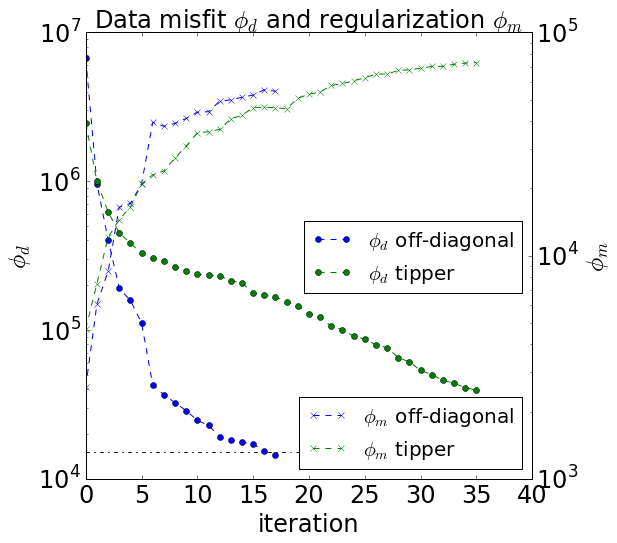

In [40]:
fig, ax1 = plt.subplots(figsize=(8,8))
ax2=ax1.twinx()
convergeCurves(runT4fFiles,ax1,ax2,'b','b',fontsize=24)
convergeCurves(runT4tFiles,ax1,ax2,'g','g',fontsize=24)
ax1.legend(('$\phi_d$ off-diagonal','$\phi_d$ tipper'),loc='upper right', bbox_to_anchor=(1., 0.6),fontsize=20)
ax2.legend(('$\phi_m$ off-diagonal','$\phi_m$ tipper'),loc=4,fontsize=20)
plt.show()
fig.savefig('../Poster/MT_convergenceCurves.png',dpi=300)

In [41]:
#Load Model
mesh, modDict = simpeg.Mesh.TensorMesh.readVTK('../ForwardModeling_noExtension_Coarse/nsmesh_CoarseHKPK1_NoExtension.vtr')
sigma = modDict['S/m']

In [42]:
#Load Model Off-diagonal
mesh,inv= simpeg.Mesh.TensorMesh.readVTK('./run_thibaut4_off/recoveredMod_run_thibaut4_off_it18.vtr')
siginv=inv['S/m']

In [43]:
#Load Model Tipper
mesh,invtip= simpeg.Mesh.TensorMesh.readVTK('./run_thibaut4_tip/recoveredMod_run_thibaut4_tip_it36.vtr')
siginvtip=invtip['S/m']

In [44]:
# Define the area of interest
#bw, be = 557100, 557580
#bs, bn = 7133340, 7133960 
#bb, bt = 0,480

In [47]:
# Define a resized area of interest
bw, be = 557100, 557580
bs, bn = 7133340, 7133820 
bb, bt = 0,480

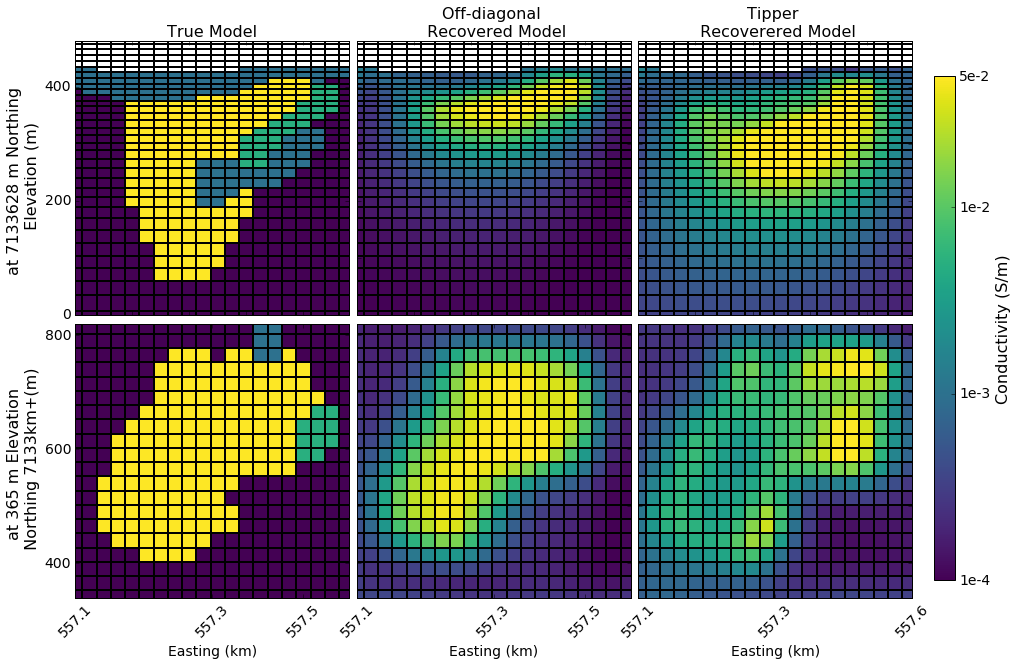

In [46]:
#Poster Figure

vmin,vmax=-4,-1.3
ticksize=14
fontsize=14
titlesize=16

slice_ver=20
slice_hor=40

fig = plt.figure(figsize=(15,10))
ax0=plt.subplot2grid((12,18), (0, 0),colspan=6,rowspan=6)
#ax4=plt.subplot2grid((10,12),(0,11),colspan=1,rowspan=10)
#ax0 = plt.subplot(221)
model = sigma.reshape(mesh.vnC,order='F')
mask0 = np.ma.masked_where(model==1e-8,model)

a = ax0.pcolormesh(mesh.gridCC[:,0].reshape(mesh.vnC,order='F')[:,slice_ver,:],
                   mesh.gridCC[:,2].reshape(mesh.vnC,order='F')[:,slice_ver,:],np.log10(mask0[:,slice_ver,:]),
                   edgecolor='k',cmap='viridis')

ax0.set_xlim([bw,be])
ax0.set_ylim([0,bt])
ax0.set_aspect("equal")

ax0.set_ylabel(("at %1.0f m Northing \n Elevation (m)")%(np.unique(mesh.gridCC[:,1].reshape(mesh.vnC,order='F')[:,slice_ver,:])[0]),fontsize=titlesize)
ax0.set_title("True Model",fontsize=titlesize)

ax0.set_xticklabels([])

ax0.set_yticks([0,200,400])
ax0.tick_params(axis='y', labelsize=ticksize)

ax1=plt.subplot2grid((12,18), (0, 6),colspan=6,rowspan=6)

sinv = siginv.reshape(mesh.vnC,order='F')
mask1= np.ma.masked_where(sinv<=9.9e-7,sinv)

b = ax1.pcolormesh(mesh.gridCC[:,0].reshape(mesh.vnC,order='F')[:,slice_ver,:],
                   mesh.gridCC[:,2].reshape(mesh.vnC,order='F')[:,slice_ver,:],np.log10(mask1[:,slice_ver,:]),
                   edgecolor='k',cmap='viridis',vmin=vmin,vmax=vmax)

ax1.set_xlim([bw,be])
ax1.set_ylim([0,bt])
ax1.set_aspect("equal")
ax1.set_yticklabels([])
ax1.set_title(("Off-diagonal \n Recovered Model")%(np.unique(mesh.gridCC[:,1].reshape(mesh.vnC,order='F')[:,slice_ver,:])[0]),fontsize=titlesize)
ax1.set_xticklabels([])

ax2=plt.subplot2grid((12,18), (6, 0),colspan=6,rowspan=6)
#ax2 = plt.subplot(223)


#print np.unique(mesh.gridCC[:,2].reshape(mesh.vnC,order='F')[:,:,slice])

c = ax2.pcolormesh(mesh.gridCC[:,0].reshape(mesh.vnC,order='F')[:,:,slice_hor],mesh.gridCC[:,1].reshape(mesh.vnC,order='F')[:,:,slice_hor],
                   np.log10(model[:,:,slice_hor]),edgecolor='k',cmap='viridis',vmin=vmin,vmax=vmax)

ax2.set_xlim([bw,be])
ax2.set_ylim([bs,bn])
ax2.set_aspect("equal")
ax2.set_xticks([bw,(bw+be)/2,be-80])
ax2.set_xticklabels([bw,(bw+be)/2,be-80])
ax2.set_xticklabels(np.round((np.array(ax2.get_xticks().tolist(),dtype=float)/100).tolist())/10)
ax2xlabels=ax2.get_xticklabels()
for label in ax2xlabels:
    label.set_rotation(45)
    
ax2.set_yticks([7133400,7133600,7133800])
ax2.set_yticklabels([400,600,800])
ax2.tick_params(axis='y', labelsize=ticksize)

ax2.set_xlabel("Easting (km)",fontsize=fontsize)
ax2.set_ylabel(("at %1.0f m Elevation \n Northing 7133km+(m)")%(np.unique(mesh.gridCC[:,2].reshape(mesh.vnC,order='F')[:,:,slice_hor])[0]),fontsize=titlesize)

ax3=plt.subplot2grid((12,18), (6, 6),colspan=6,rowspan=6)

d = ax3.pcolormesh(mesh.gridCC[:,0].reshape(mesh.vnC,order='F')[:,:,slice_hor],mesh.gridCC[:,1].reshape(mesh.vnC,order='F')[:,:,slice_hor],
                   np.log10(sinv[:,:,slice_hor]),edgecolor='k',cmap='viridis',vmin=vmin,vmax=vmax)

ax3.set_xlim([bw,be])
ax3.set_ylim([bs,bn])
ax3.set_aspect("equal")

ax3.set_xticks([bw,(bw+be)/2,be-80])
ax3.set_xticklabels([bw,(bw+be)/2,be-80])
ax3.set_xticklabels(np.round((np.array(ax3.get_xticks().tolist(),dtype=float)/100).tolist())/10)

ax3xlabels=ax3.get_xticklabels()
for label in ax3xlabels:
    label.set_rotation(45)
    
ax3.set_yticklabels([])
ax3.set_xlabel("Easting (km)",fontsize=fontsize)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = plt.colorbar(c, cax=cbar_ax)
cbar.set_label("Conductivity (S/m)",fontsize=titlesize)
cbar.set_ticks([-4,-3,-2,-1.3])
cbar.set_ticklabels(['1e-4','1e-3','1e-2','5e-2'])

sinvtip = siginvtip.reshape(mesh.vnC,order='F')
mask2= np.ma.masked_where(sinvtip<=9.9e-7,sinvtip)

ax4=plt.subplot2grid((12,18), (0, 12),colspan=6,rowspan=6)

e = ax4.pcolormesh(mesh.gridCC[:,0].reshape(mesh.vnC,order='F')[:,slice_ver,:],
                   mesh.gridCC[:,2].reshape(mesh.vnC,order='F')[:,slice_ver,:],np.log10(mask2[:,slice_ver,:]),
                   edgecolor='k',cmap='viridis',vmin=vmin,vmax=vmax)

ax4.set_xlim([bw,be])
ax4.set_ylim([0,bt])
ax4.set_aspect("equal")
ax4.set_yticklabels([])
ax4.set_title(("Tipper \n Recoverered Model")%(np.unique(mesh.gridCC[:,1].reshape(mesh.vnC,order='F')[:,slice_ver,:])[0]),fontsize=titlesize)
ax4.set_xticklabels([])

ax5=plt.subplot2grid((12,18), (6, 12),colspan=6,rowspan=6)


f = ax5.pcolormesh(mesh.gridCC[:,0].reshape(mesh.vnC,order='F')[:,:,slice_hor],mesh.gridCC[:,1].reshape(mesh.vnC,order='F')[:,:,slice_hor],
                   np.log10(mask2[:,:,slice_hor]),edgecolor='k',cmap='viridis',vmin=vmin,vmax=vmax)

ax5.set_xlim([bw,be])
ax5.set_ylim([bs,bn])
ax5.set_aspect("equal")

ax5.set_xticks([bw,(bw+be)/2,be])
ax5.set_xticklabels([bw,(bw+be)/2,be])
ax5.set_xticklabels(np.round((np.array(ax5.get_xticks().tolist(),dtype=float)/100).tolist())/10)

ax5xlabels=ax5.get_xticklabels()
for label in ax5xlabels:
    label.set_rotation(45)

ax5.set_yticklabels([])


ax5.set_xlabel("Easting (km)",fontsize=fontsize)

for ax in [ax0,ax1,ax2,ax3,ax4,ax5,cbar.ax]:
    ax.tick_params(axis='y', labelsize=ticksize)
    ax.tick_params(axis='x', labelsize=ticksize)


plt.show()

In [24]:
fig.savefig('../Poster/MT_offtip_results.png',dpi=300)

In [25]:
# Load the FW tipper data from last iteration
drecAllft = np.load('../FW_Test_it10_offdiag/MTdataStArr_recoveredMod_run_thibaut4_off_it10.npy')
# Select larger frequency band for the MT data
indMTFreqft = np.sum([drecAllft['freq'] == val for val in  np.unique(drecAllft['freq'])],axis=0,dtype=bool)
mtRecArrft = drecAllft[indMTFreqft][['freq','x','y','z','tzx','tzy']]
dUseft = NSEM.Data.fromRecArray(mtRecArrft)
# Extract to survey
surveyft = dUseft.survey

In [28]:
# # Add noise to the data
dobsft, freqArr, rxT = getDataInfo(dUseft)
# Set the data

survey.dobs = dobsft
# Assign std based on- and off-diagonal parts of the impedance tensor
std = np.ones_like(dobsft)*.05 # 5% on all off-diagonals
# std[np.array([ ('xx' in l or 'yy' in l) for l in rxT])] = 0.15 # 15% on the on-diagonal
survey.std = np.abs(survey.dobs*std) #+ 0.01*np.linalg.norm(survey.dobs) #survey.dobs*0 + std
# Estimate a floor for the data.
# Use the 10% of the mean of the off-diagonals for each frequency
floor = np.zeros_like(dobsft)
offind = np.array([('zxy' in l or 'zyx' in l) for l in rxT],bool)
onind = np.array([('zxx' in l or 'zyy' in l) for l in rxT],bool)
tipind = np.array([('tzx' in l or 'tzy' in l) for l in rxT],bool)

assert (offind+tipind+onind).all()

for f in np.unique(freqArr):
    freqInd = freqArr == f
    floorFreq = floor[freqInd]
    offD = np.sort(np.abs(dobs[freqInd*offind]))
    floor[freqInd] = 0.0001*np.mean(offD)
    onD = np.sort(np.abs(dobs[freqInd*onind]))
    floor[freqInd*onind] = 0.1*np.mean(onD)
    # Constant floor for the tipper.
    floor[freqInd*tipind] = 0.001

# Assign the data weight
Wd = 1./(survey.std + floor)

epsft=(survey.std + floor)

In [ ]:
phi_d_ft = (dobsft-dobst)/epsft

In [ ]:
n = plt.hist(phi_d_ft,bins=50,color='green')

### Run_thibaut4_tip

In [13]:
# Load the data
drecAllt = np.load('./run_thibaut4_tip/MTdataStArr_nsmesh_HKPK1Coarse_noExtension.npy')
# Select larger frequency band for the MT data
indMTFreqt = np.sum([drecAllt['freq'] == val for val in  np.unique(drecAllt['freq'])],axis=0,dtype=bool)
mtRecArrt = drecAllt[indMTFreqt][['freq','x','y','z','tzx','tzy']]
dUset = NSEM.Data.fromRecArray(mtRecArrt)
# Extract to survey
survey = dUset.survey

# # Add noise to the data
dobst, freqArr, rxT = getDataInfo(dUset)
# Set the data

survey.dobs = dobst
# Assign std based on- and off-diagonal parts of the impedance tensor
std = np.ones_like(dobst)*.05 # 5% on all off-diagonals
# std[np.array([ ('xx' in l or 'yy' in l) for l in rxT])] = 0.15 # 15% on the on-diagonal
survey.std = np.abs(survey.dobs*std) #+ 0.01*np.linalg.norm(survey.dobs) #survey.dobs*0 + std
# Estimate a floor for the data.
# Use the 10% of the mean of the off-diagonals for each frequency
floor = np.zeros_like(dobst)
offind = np.array([('zxy' in l or 'zyx' in l) for l in rxT],bool)
onind = np.array([('zxx' in l or 'zyy' in l) for l in rxT],bool)
tipind = np.array([('tzx' in l or 'tzy' in l) for l in rxT],bool)

assert (offind+tipind+onind).all()

for f in np.unique(freqArr):
    freqInd = freqArr == f
    floorFreq = floor[freqInd]
    offD = np.sort(np.abs(dobst[freqInd*offind]))
    floor[freqInd] = 0.0001*np.mean(offD)
    onD = np.sort(np.abs(dobst[freqInd*onind]))
    floor[freqInd*onind] = 0.1*np.mean(onD)
    # Constant floor for the tipper.
    floor[freqInd*tipind] = 0.001

# Assign the data weight
Wd = 1./(survey.std + floor)

epst=(survey.std + floor)

In [14]:
# # Add noise to the data
dobst, freqArr, rxT = getDataInfo(dUset)
# Set the data

survey.dobs = dobst
# Assign std based on- and off-diagonal parts of the impedance tensor
std = np.ones_like(dobst)*.05 # 5% on all off-diagonals
# std[np.array([ ('xx' in l or 'yy' in l) for l in rxT])] = 0.15 # 15% on the on-diagonal
survey.std = np.abs(survey.dobs*std) #+ 0.01*np.linalg.norm(survey.dobs) #survey.dobs*0 + std
# Estimate a floor for the data.
# Use the 10% of the mean of the off-diagonals for each frequency
floor = np.zeros_like(dobst)
offind = np.array([('zxy' in l or 'zyx' in l) for l in rxT],bool)
onind = np.array([('zxx' in l or 'zyy' in l) for l in rxT],bool)
tipind = np.array([('tzx' in l or 'tzy' in l) for l in rxT],bool)

assert (offind+tipind+onind).all()

for f in np.unique(freqArr):
    freqInd = freqArr == f
    floorFreq = floor[freqInd]
    offD = np.sort(np.abs(dobst[freqInd*offind]))
    floor[freqInd] = 0.0001*np.mean(offD)
    onD = np.sort(np.abs(dobst[freqInd*onind]))
    floor[freqInd*onind] = 0.1*np.mean(onD)
    # Constant floor for the tipper.
    floor[freqInd*tipind] = 0.001

# Assign the data weight
Wd = 1./(survey.std + floor)

epst=(survey.std + floor)

/Applications/Anaconda/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/Anaconda/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [15]:
runT4tFiles = loadInversionMakeVTRFiles('run_thibaut4_tip',mesh,mappingExpAct)

In [16]:
dpredt =runT4tFiles[-1]['dpred']

In [17]:
[i['iter'] for i in runT4tFiles]

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36]

In [18]:
phi_d_t = (dpredt-dobst)/epst

In [19]:
np.std(phi_d)

0.97183127577573492

In [20]:
np.std(phi_d_t)

1.6071295362349509

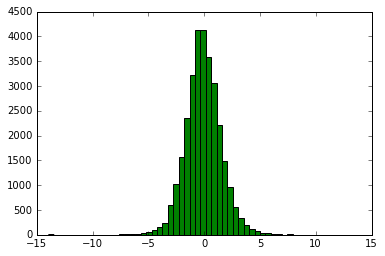

In [21]:
n = plt.hist(phi_d_t,bins=50,color='green')

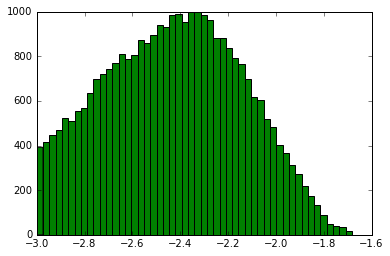

In [22]:
n = plt.hist(np.log10(np.abs(epst)),bins=50,color='green')

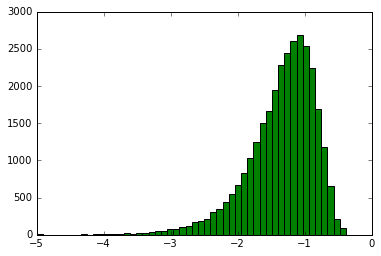

In [23]:
n = plt.hist(np.log10(np.abs(dpredt)),bins=50,color='green')

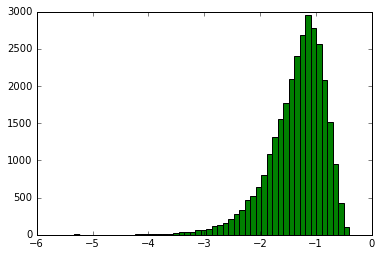

In [24]:
n = plt.hist(np.log10(np.abs(dobst)),bins=50,color='green')

In [25]:
convergeCurves(runT4tFiles)

TypeError: convergeCurves() takes exactly 6 arguments (1 given)

In [41]:
mesh,invtip= simpeg.Mesh.TensorMesh.readVTK('./run_thibaut4_tip/recoveredMod_run_thibaut4_tip_it36.vtr')
siginvtip=invtip['S/m']

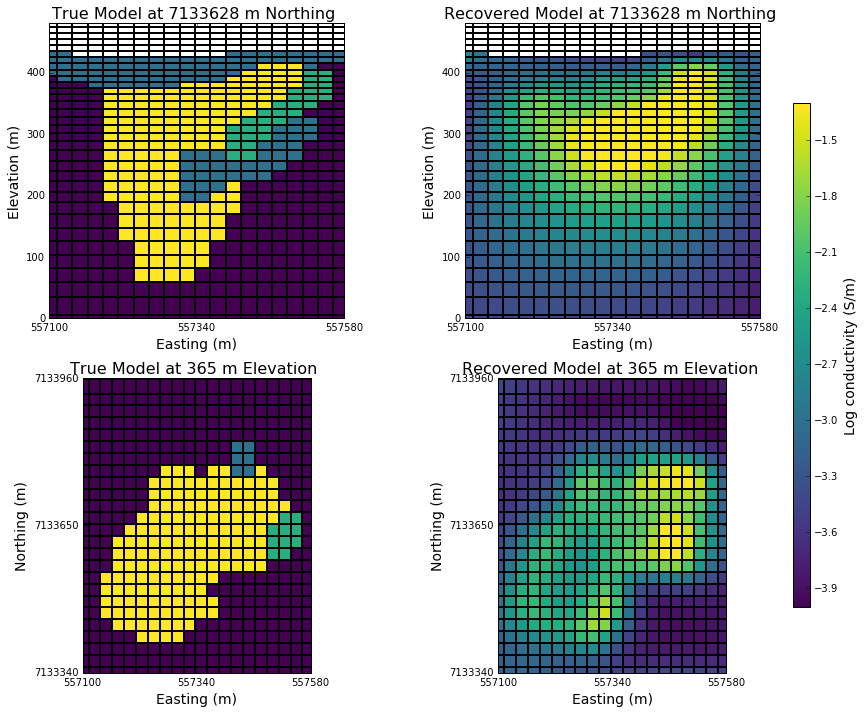

In [130]:
vmin,vmax=-4,-1.3
fontsize=14
titlesize=16

slice_ver=20
slice_hor=40


fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(12,10))
ax0=axes[0,0]
ax1=axes[0,1]
ax2=axes[1,0]
ax3=axes[1,1]
#fig = plt.figure(figsize=(10,10))
#ax0=plt.subplot2grid((10,10), (0, 0),colspan=5,rowspan=5)
#ax4=plt.subplot2grid((10,12),(0,11),colspan=1,rowspan=10)
#ax0 = plt.subplot(221)
model = sigma.reshape(mesh.vnC,order='F')
mask0 = np.ma.masked_where(model==1e-8,model)

a = ax0.pcolormesh(mesh.gridCC[:,0].reshape(mesh.vnC,order='F')[:,slice_ver,:],
                   mesh.gridCC[:,2].reshape(mesh.vnC,order='F')[:,slice_ver,:],np.log10(mask0[:,slice_ver,:]),
                   edgecolor='k',cmap='viridis')

ax0.set_xlim([bw,be])
ax0.set_ylim([0,bt])
#ax.grid(which="major")
#cb0 = plt.colorbar(a,ax=ax4)
ax0.set_aspect("equal")
cb0.set_label("Log conductivity (S/m)",fontsize=fontsize)
cb0.set_clim(vmin,vmax)
ax0.set_xlabel("Easting (m)",fontsize=fontsize)
ax0.set_ylabel("Elevation (m)",fontsize=fontsize)
ax0.set_title(("True Model at %1.0f m Northing ")%(np.unique(mesh.gridCC[:,1].reshape(mesh.vnC,order='F')[:,slice_ver,:])[0]),fontsize=titlesize)

ax0.set_xticks([bw,(bw+be)/2,be])
ax0.set_xticklabels([bw,(bw+be)/2,be])

#ax1=plt.subplot2grid((10,10), (0, 5),colspan=5,rowspan=5)
#ax1 = plt.subplot(222)

sinvtip = siginvtip.reshape(mesh.vnC,order='F')
mask1= np.ma.masked_where(sinvtip<=9.9e-7,sinvtip)

b = ax1.pcolormesh(mesh.gridCC[:,0].reshape(mesh.vnC,order='F')[:,slice_ver,:],
                   mesh.gridCC[:,2].reshape(mesh.vnC,order='F')[:,slice_ver,:],np.log10(mask1[:,slice_ver,:]),
                   edgecolor='k',cmap='viridis',vmin=vmin,vmax=vmax)

ax1.set_xlim([bw,be])
ax1.set_ylim([0,bt])
#ax.grid(which="major")
#cb1 = plt.colorbar(b,ax=ax1)
#cb1.set_clim(vmin,vmax)
ax1.set_aspect("equal")
#cb1.set_label("Log conductivity (S/m)",fontsize=fontsize)
ax1.set_xlabel("Easting (m)",fontsize=fontsize)
ax1.set_ylabel("Elevation (m)",fontsize=fontsize)
ax1.set_title(("Recovered Model at %1.0f m Northing ")%(np.unique(mesh.gridCC[:,1].reshape(mesh.vnC,order='F')[:,slice_ver,:])[0]),fontsize=titlesize)

ax1.set_xticks([bw,(bw+be)/2,be])
ax1.set_xticklabels([bw,(bw+be)/2,be])

#ax2=plt.subplot2grid((10,10), (5, 0),colspan=5,rowspan=5)
#ax2 = plt.subplot(223)


#print np.unique(mesh.gridCC[:,2].reshape(mesh.vnC,order='F')[:,:,slice])

c = ax2.pcolormesh(mesh.gridCC[:,0].reshape(mesh.vnC,order='F')[:,:,slice_hor],mesh.gridCC[:,1].reshape(mesh.vnC,order='F')[:,:,slice_hor],
                   np.log10(model[:,:,slice_hor]),edgecolor='k',cmap='viridis',vmin=vmin,vmax=vmax)

ax2.set_xlim([bw,be])
ax2.set_ylim([bs,bn])
#ax.grid(which="major")
#cb2 = plt.colorbar(c,ax=ax2)
ax2.set_aspect("equal")
#cb2.set_label("Log conductivity (S/m)",fontsize=fontsize)
#cb2.set_clim(vmin,vmax)
ax2.set_xticks([bw,(bw+be)/2,be])
ax2.set_xticklabels([bw,(bw+be)/2,be])

ax2.set_yticks([bs,(bs+bn)/2,bn])
ax2.set_yticklabels([bs,(bs+bn)/2,bn])

ax2.set_xlabel("Easting (m)",fontsize=fontsize)
ax2.set_ylabel("Northing (m)",fontsize=fontsize)
ax2.set_title(("True Model at %1.0f m Elevation ")%(np.unique(mesh.gridCC[:,2].reshape(mesh.vnC,order='F')[:,:,slice_hor])[0]),fontsize=titlesize)

#ax3=plt.subplot2grid((10,10), (5, 5),colspan=5,rowspan=5)
#ax3 = plt.subplot(224)

d = ax3.pcolormesh(mesh.gridCC[:,0].reshape(mesh.vnC,order='F')[:,:,slice_hor],mesh.gridCC[:,1].reshape(mesh.vnC,order='F')[:,:,slice_hor],
                   np.log10(sinvtip[:,:,slice_hor]),edgecolor='k',cmap='viridis',vmin=vmin,vmax=vmax)

ax3.set_xlim([bw,be])
ax3.set_ylim([bs,bn])
#ax.grid(which="major")
#cb3 = plt.colorbar(d,ax=ax3)
#cb3.set_clim(vmin,vmax)
ax3.set_aspect("equal")

ax3.set_xticks([bw,(bw+be)/2,be])
ax3.set_xticklabels([bw,(bw+be)/2,be])

ax3.set_yticks([bs,(bs+bn)/2,bn])
ax3.set_yticklabels([bs,(bs+bn)/2,bn])

#cb3.set_label("Log conductivity (S/m)",fontsize=fontsize)
ax3.set_xlabel("Easting (m)",fontsize=fontsize)
ax3.set_ylabel("Northing (m)",fontsize=fontsize)
ax3.set_title(("Recovered Model at %1.0f m Elevation ")%(np.unique(mesh.gridCC[:,2].reshape(mesh.vnC,order='F')[:,:,slice_hor])[0]),fontsize=titlesize)


fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cbar = plt.colorbar(c, cax=cbar_ax)
cbar.set_label("Log conductivity (S/m)",fontsize=fontsize)


plt.tight_layout()

fig.savefig('../Poster/MT_tipper.png',dpi=600)

In [128]:
fig.savefig??

### run1


In [6]:
run1Files = loadInversionMakeVTRFiles('run1',mesh,mappingExpAct)

In [7]:
ls run1

001-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it10.vtr
002-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it11.vtr
003-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it12.vtr
004-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it13.vtr
005-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it14.vtr
006-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it15.vtr
007-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it16.vtr
008-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it17.vtr
009-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it18.vtr
010-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it19.vtr
011-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it1.vtr
012-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it20.vtr
013-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it21.vtr
014-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it22.vtr
015-InversionModel-2016-05-27-12-14.npz  recovere

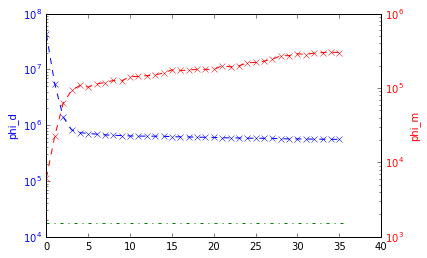

In [8]:
%matplotlib inline
convergeCurves(run1Files)

In [9]:
[res['iter'] for res in run1Files]

[array(11),
 array(1),
 array(9),
 array(5),
 array(15),
 array(22),
 array(8),
 array(4),
 array(6),
 array(13),
 array(18),
 array(31),
 array(27),
 array(20),
 array(7),
 array(35),
 array(12),
 array(28),
 array(25),
 array(16),
 array(19),
 array(10),
 array(23),
 array(26),
 array(2),
 array(14),
 array(3),
 array(32),
 array(21),
 array(36),
 array(29),
 array(24),
 array(33),
 array(34),
 array(17),
 array(30)]

In [10]:
%matplotlib qt
sys.path.append('/home/gudni/Dropbox/code/python/MTview/')
import interactivePlotFunctions as iPf

In [11]:
finData = NSEM.Data(survey,run1Files[0]['dpred']).toRecArray('Complex')

/home/gudni/anaconda2/lib/python2.7/site-packages/numpy/ma/core.py:2915: FutureWarning: Numpy has detected that you (may be) writing to an array returned
by numpy.diagonal or by selecting multiple fields in a structured
array. This code will likely break in a future numpy release --
see numpy.diagonal or arrays.indexing reference docs for details.
The quick fix is to make an explicit copy (e.g., do
arr.diagonal().copy() or arr[['f0','f1']].copy()).
  if (obj.__array_interface__["data"][0]
/home/gudni/anaconda2/lib/python2.7/site-packages/numpy/ma/core.py:2916: FutureWarning: Numpy has detected that you (may be) writing to an array returned
by numpy.diagonal or by selecting multiple fields in a structured
array. This code will likely break in a future numpy release --
see numpy.diagonal or arrays.indexing reference docs for details.
The quick fix is to make an explicit copy (e.g., do
arr.diagonal().copy() or arr[['f0','f1']].copy()).
  != self.__array_interface__["data"][0]):


In [12]:
%matplotlib qt
iPf.MTinteractiveMap([dUse.toRecArray('Complex'),finData])

### run2

In [13]:
run2Files = loadInversionMakeVTRFiles('run2',mesh,mappingExpAct)

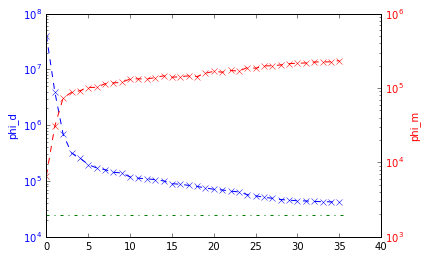

In [14]:
%matplotlib inline
convergeCurves(run2Files)

In [16]:
finData = NSEM.Data(survey,run2Files[0]['dpred']).toRecArray('Complex')

AssertionError: v must have the correct number of data.

## run3

In [17]:
run3Files = loadInversionMakeVTRFiles('run3',mesh,mappingExpAct)

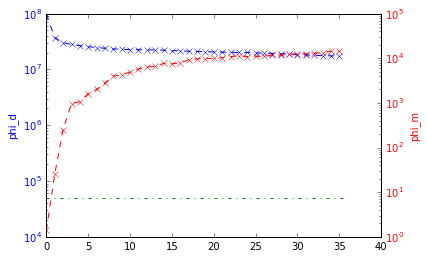

In [18]:
%matplotlib inline
convergeCurves(run3Files)

## run4

In [15]:
run4Files = loadInversionMakeVTRFiles('run4',mesh,mappingExpAct)

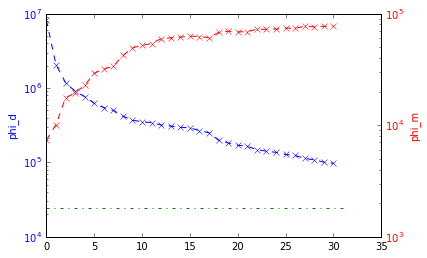

In [16]:
%matplotlib inline
convergeCurves(run4Files)